In [2]:
import sys
sys.path.append('./')
import numpy as np
import keras.backend as K
import tensorflow as tf
from keras.layers import Conv2D, Dense, DepthwiseConv2D,add
from keras.optimizers import SGD, Adam
import numpy as np
import math
import keras
from PIL import Image
from random import shuffle
from keras import layers as KL
from Anchors import get_anchors
from Datasets import SSDDatasets
from learning_rate import WarmUpCosineDecayScheduler
from loss import MultiboxLoss
from Models import SSD300
from utils import get_classes

In [4]:
from keras.regularizers import l2

if __name__ == "__main__":
    
    # 设置训练参数
    Epoch = 300  # 训练100 epochs
    lr = 1e-3  # Adam优化器，所以较小的学习率
    optimizer_type = "Adam"
    momentum = 0.937
    batch_size = 32
    imgcolor = 'grey'  # imgcolor选“rgb” or “grey”, 则处理图像变单通道或者三通道
    
    # 设置SSD参数
    cls_name_path = "./model_data/voc_classes.txt"  # 导入目标检测类别；
    input_shape = [120, 160]  # 输入的尺寸大小
    anchor_size = [32, 59, 86, 113, 141, 168]  # 用于设定先验框的大小，根据公式计算而来；如果要检测小物体，修改浅层先验框的大小，越小的话，识别的物体越小；    
    train_annotation_path = '2007_train.txt'  # 训练图片路径和标签
    val_annotation_path = '2007_val.txt'  # 验证图片路径和标签
    
    # 1. 获取classes和anchor
    class_names, num_cls = get_classes(cls_name_path)
    num_cls += 1  # 增加一个背景类别
    print("class_names:", class_names, "num_classes:", num_cls)
    
    # 2. 获取anchors, 输出的是归一化之后的anchors
    anchor = get_anchors(input_shape, anchor_size)
    print("type:",type(anchor), "shape:", np.shape(anchor))

    # 3. 模型编译
    K.clear_session()
    # model_path = ""
    model_path = "./202300317_good_detection.h5"
    model = SSD300((input_shape[0], input_shape[1], 1), num_cls)
    # model.save("template.h5")
    # model.summary()
    model.load_weights(model_path, by_name = True, skip_mismatch=True)
       
    
    # 4. 优化器
    # optimizer = Adam(lr = lr, beta_1=momentum)
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    
    # 5. 导入数据集
    with open(train_annotation_path, encoding='utf-8') as f:
        train_lines = f.readlines()
    with open(val_annotation_path, encoding='utf-8') as f:
        val_lines = f.readlines()
    num_train = len(train_lines)
    num_val = len(val_lines)
    epoch_step = num_train // batch_size
    epoch_step_val = num_val // batch_size
    train_dataloader = SSDDatasets(train_lines, input_shape, anchor, batch_size, num_cls, train=False, imgcolor=imgcolor)
    val_dataloader = SSDDatasets(val_lines, input_shape, anchor, batch_size, num_cls, train=False, imgcolor=imgcolor)
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    
    # 6. 编译模型
    # losses = {'mbox_loc_final':MultiboxLoss(num_cls, neg_pos_ratio=3.0).compute_loc_loss,
            #   'cls_conf_final':MultiboxLoss(num_cls, neg_pos_ratio=3.0).compute_conf_loss}
    # losses2 = [MultiboxLoss(num_cls, neg_pos_ratio=3.0).compute_loc_loss,MultiboxLoss(num_cls, neg_pos_ratio=3.0).compute_conf_loss]
    model.compile(optimizer=optimizer, loss = MultiboxLoss(num_cls, neg_pos_ratio=3.0).compute_loss)
    
    # 7. 设计learning rate;
    total_steps = int(Epoch * num_train / batch_size)
    # 7.1 compute the number of warmup batches.
    warmup_epochs = 10
    warmup_steps = int(warmup_epochs * num_train / batch_size)
    # 7.2 create the learning rate scheduler
    warm_up_lr = WarmUpCosineDecayScheduler(learning_rate_base=lr,
                                            total_steps=total_steps,
                                            warmup_learning_rate=4e-06,
                                            warmup_steps=warmup_steps,
                                            hold_base_rate_steps=20)
    
    # 8. 开始训练；
    history = model.fit_generator(
        generator=train_dataloader,
        steps_per_epoch=epoch_step,
        validation_data=val_dataloader,
        validation_steps=epoch_step_val,
        epochs=Epoch,
        callbacks = [warm_up_lr]   
    )
    model.save("20230803_good_detection.h5")
    model.save("20230803_good_detection.pb")

class_names: ['good'] num_classes: 2
type: <class 'numpy.ndarray'> shape: (1242, 4)
Train on 346 samples, val on 346 samples, with batch size 32.
Epoch 1/300


/home/zhangyouan/anaconda3/envs/stc/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/tmp/ipykernel_28745/1207802890.py:75: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


10/10 [==============================] - 3s 159ms/step - loss: 0.5536 - val_loss: 1.1368
Epoch 2/300
10/10 [==============================] - 1s 110ms/step - loss: 0.5600 - val_loss: 1.1167
Epoch 3/300
10/10 [==============================] - 1s 113ms/step - loss: 0.5732 - val_loss: 1.1433
Epoch 4/300
10/10 [==============================] - 1s 115ms/step - loss: 0.5818 - val_loss: 1.1193
Epoch 5/300
10/10 [==============================] - 1s 115ms/step - loss: 0.5674 - val_loss: 1.1748
Epoch 6/300
10/10 [==============================] - 1s 115ms/step - loss: 0.5929 - val_loss: 1.1515
Epoch 7/300
10/10 [==============================] - 1s 113ms/step - loss: 0.5952 - val_loss: 1.1305
Epoch 8/300
10/10 [==============================] - 1s 112ms/step - loss: 0.5935 - val_loss: 1.2020
Epoch 9/300
10/10 [==============================] - 1s 111ms/step - loss: 0.5996 - val_loss: 1.1456
Epoch 10/300
10/10 [==============================] - 1s 113ms/step - loss: 0.5849 - val_loss: 1.1789
E

INFO:tensorflow:Assets written to: 20230803_good_detection.pb/assets


INFO:tensorflow:Assets written to: 20230803_good_detection.pb/assets


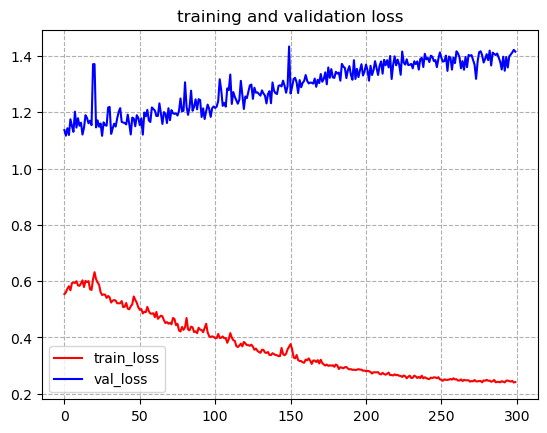

In [10]:
# 显示训练loss;
import matplotlib.pyplot as plt
from pprint import pprint

# pprint(history.__dict__)

# acc = history.history['accuracy']
# val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(loss)) # Get number of epochs
 
#-----------------------------------------------------------
# Plot training and validation accuracy per epoch
#-----------------------------------------------------------
# plt.plot(epochs, acc, 'r', label = "tra_acc")
# plt.plot(epochs ,val_acc, 'b', label = "val_acc")
# plt.title("training and validation accuracy")
# plt.legend(loc=0)
# plt.grid(ls='--')  # 生成网格
# plt.show()
# 曲线呈直线是因为epochs/轮次太少
#-----------------------------------------------------------
# Plot training and validation loss per epoch
#-----------------------------------------------------------
plt.plot(epochs, loss, 'r', label = "train_loss")
plt.plot(epochs ,val_loss, 'b', label = "val_loss")
plt.title("training and validation loss")
plt.legend(loc=0)
plt.grid(ls='--')  # 生成网格
plt.show()
# 曲线呈直线是因为epochs/轮次太少

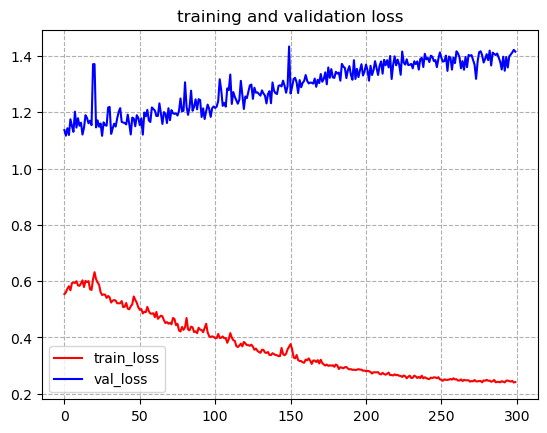

In [11]:
# 显示训练loss;
import matplotlib.pyplot as plt
from pprint import pprint

# pprint(history.__dict__)

# acc = history.history['accuracy']
# val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(loss)) # Get number of epochs
 
#-----------------------------------------------------------
# Plot training and validation accuracy per epoch
#-----------------------------------------------------------
# plt.plot(epochs, acc, 'r', label = "tra_acc")
# plt.plot(epochs ,val_acc, 'b', label = "val_acc")
# plt.title("training and validation accuracy")
# plt.legend(loc=0)
# plt.grid(ls='--')  # 生成网格
# plt.show()
# 曲线呈直线是因为epochs/轮次太少
#-----------------------------------------------------------
# Plot training and validation loss per epoch
#-----------------------------------------------------------
plt.plot(epochs, loss, 'r', label = "train_loss")
plt.plot(epochs ,val_loss, 'b', label = "val_loss")
plt.title("training and validation loss")
plt.legend(loc=0)
plt.grid(ls='--')  # 生成网格
plt.show()
# 曲线呈直线是因为epochs/轮次太少